### World Data Science Institute Internship
#### Stock Prediction with  Q Learning 
#### Deep Reinforcement Learning with Microsoft Azure

By Brandon Oppong-Antwi



----

Important Notes on Installations:

Python Version: Python 3

Tensorflow Version: Tensorflow 2.30.00

Pytorch Version: Pytorch  1.6.0 with CUDA 101

Operating System: Windows 10

In [10]:

#import the dependecies 
import numpy as np #linear algebra
import pandas as pd #dataframe
import tensorflow as tf #machine learning
import matplotlib.pyplot as plt #visualization
import seaborn as sns #data visualization
sns.set()

In [11]:
#read the data frame
df = pd.read_csv('Users/brandono/SQ.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-03,62.430000,63.980000,60.959999,61.130001,61.130001,12051700
1,2019-09-04,61.750000,62.689999,60.770000,61.169998,61.169998,6637100
2,2019-09-05,61.880001,63.470001,61.668999,63.020000,63.020000,8160400
3,2019-09-06,63.500000,63.849998,61.889999,62.000000,62.000000,4744100
4,2019-09-09,62.549999,62.730000,59.070000,61.470001,61.470001,11684400


In [12]:
from collections import deque #used to add or remove elements from both ends of a deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [13]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 30.260015.3, cost: 0.419761, total money: 10030.260015
epoch: 20, total rewards: 82.720012.3, cost: 0.346855, total money: 10082.720012
epoch: 30, total rewards: 79.150005.3, cost: 0.287547, total money: 10079.150005
epoch: 40, total rewards: 79.780010.3, cost: 0.243031, total money: 10079.780010
epoch: 50, total rewards: 58.340007.3, cost: 0.209340, total money: 10058.340007
epoch: 60, total rewards: 75.440010.3, cost: 0.180653, total money: 10075.440010
epoch: 70, total rewards: 82.200011.3, cost: 0.157445, total money: 10082.200011
epoch: 80, total rewards: 80.800006.3, cost: 0.209083, total money: 10080.800006
epoch: 90, total rewards: 94.170013.3, cost: 0.124253, total money: 10094.170013
epoch: 100, total rewards: 98.200009.3, cost: 0.109747, total money: 10098.200009
epoch: 110, 

In [14]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 61.130001, total balance 9938.869999
day 1: buy 1 unit at price 61.169998, total balance 9877.700001
day 2: buy 1 unit at price 63.020000, total balance 9814.680001
day 3, sell 1 unit at price 62.000000, investment 1.423195 %, total balance 9876.680001,
day 5, sell 1 unit at price 60.549999, investment -1.013567 %, total balance 9937.230000,
day 7: buy 1 unit at price 57.790001, total balance 9879.439999
day 8: buy 1 unit at price 58.290001, total balance 9821.149998
day 11, sell 1 unit at price 59.750000, investment -5.188829 %, total balance 9880.899998,
day 12, sell 1 unit at price 59.029999, investment 2.145696 %, total balance 9939.929997,
day 14: buy 1 unit at price 56.759998, total balance 9883.169999
day 16: buy 1 unit at price 58.509998, total balance 9824.660001
day 18, sell 1 unit at price 60.750000, investment 4.220276 %, total balance 9885.410001,
day 19, sell 1 unit at price 61.950001, investment 9.143769 %, total balance 9947.360002,
day 20: bu

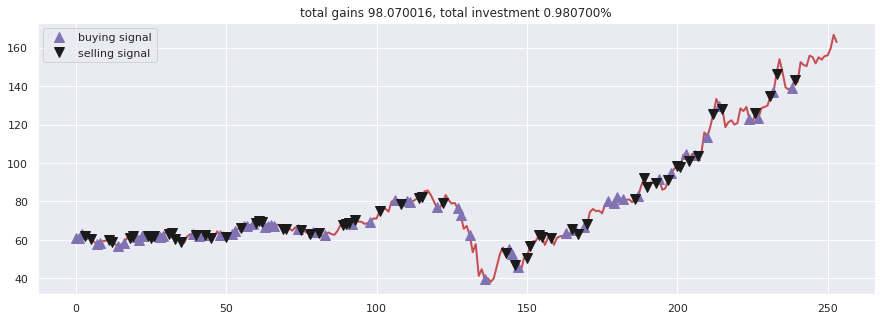

In [15]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()